Random Forest using Kaggle Animal Shelter Dataset
https://www.kaggle.com/c/shelter-animal-outcomes

# Pre-processing the animal shelter dataset

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, log_loss, average_precision_score

from textblob import TextBlob

import logging

%matplotlib inline

In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [2]:
# Set up my data directories from different machines

mac_data_dir = '/Users/christopherallison/Documents/Coding/Data'
linux_data_dir = '/home/chris/data'
win_data_dir = u'C:\\Users\\Owner\\Documents\\Data'

In [3]:
# Set data directory for example

data_dir = mac_data_dir

In [6]:
# Load TRAINING DATA

train_df = pd.read_csv(os.path.join(data_dir, 'shelter_train.csv'), header=0)        # Load the train file into a dataframe

In [7]:
# Data exploration - what headers do we have?

train_df.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [9]:
# At first blush, 

train_dogs = train_df.where(train_df['AnimalType']=='Dog')

# This creates a DF with NaN where non-Dogs used to be, so we

train_dogs.dropna(inplace=True)

In [10]:
# Let's look at our data

train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
12,A684601,Rocket,2016-02-03 11:27:00,Adoption,Foster,Dog,Neutered Male,4 years,Pit Bull Mix,Brown
20,A670658,Anders,2014-01-19 15:03:00,Transfer,Partner,Dog,Intact Male,2 months,Queensland Heeler Mix,Black/White
31,A707341,Murphy,2015-07-15 15:25:00,Transfer,Partner,Dog,Intact Male,4 months,Labrador Retriever Mix,Black/White


In [14]:
# And get a better overall feel for it.

train_dogs.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color
count,3950,3950,3950,3950,3950,3950,3950,3950,3950
unique,3950,2138,3571,4,14,5,35,626,163
top,A714899,Bella,2015-11-23 00:00:00,Transfer,Partner,Neutered Male,2 years,Pit Bull Mix,Black/White
freq,1,33,8,2673,2673,1562,740,614,423


Of interest - our original dataset was 27,600 animals - only 3950 are dogs

In [15]:
# Now that we're only looking at dogs, we can drop this as a variable

train_dogs.AnimalType.unique()
train_dogs.drop('AnimalType', 1, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'AnimalType'

In [12]:
# So let's see what outcomes we're mapping against.

outcomes = train_dogs.OutcomeType.unique()
outcomes

array(['Adoption', 'Transfer', 'Euthanasia', 'Died'], dtype=object)

Of interest - Dogs aren't returned to their owners. Cats are. WTF?

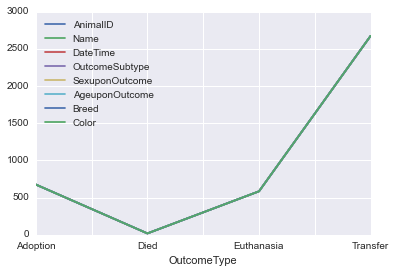

In [16]:
# Let's explore the data a bit more.  How do these outcomes map to our data?

counts = train_dogs.groupby('OutcomeType').count()
counts.plot()

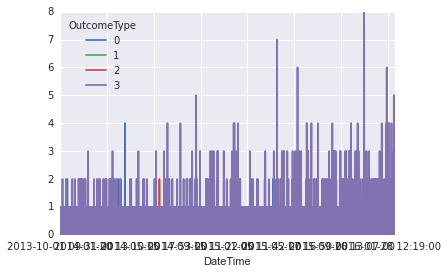

In [37]:
dates_cross = pd.crosstab(train_dogs.DateTime, train_dogs.OutcomeType)
dates_cross.plot()

### Prepare Y labels

In [18]:
#One of the key things we need to do is transform our outcomes into matrices required for result probabilities.  Let's do this.

from sklearn import preprocessing

# This code takes our text labels and creates an encoder that we use
# To transform them into an array

encoder = preprocessing.LabelEncoder()
encoder.fit(outcomes)
encoded_y = encoder.transform(outcomes)
encoded_y
#We can also inverse_transform them back.
list(encoder.inverse_transform([0, 1, 2, 3]))
#We still need to transform the array into a matrix - this is called one hot encoding. It allows us to track the probability of each possible outcome separately.
# convert integers into dummy variables (one hot encoding)
from keras.utils import np_utils

# We'll practice with the dummy for now, but we'll transform the full labels later.
dummy_y = np_utils.to_categorical(encoded_y)
dummy_y
#We'll transform the labels into their array value, though.
train_dogs.OutcomeType = encoder.transform(train_dogs.OutcomeType)

array([0, 3, 2, 1])

And here is our dataframe again.

In [23]:
train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color
2,A686464,Pearce,2015-01-31 12:28:00,0,Foster,Neutered Male,2 years,Pit Bull Mix,Blue/White
5,A677334,Elsa,2014-04-25 13:04:00,3,Partner,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
12,A684601,Rocket,2016-02-03 11:27:00,0,Foster,Neutered Male,4 years,Pit Bull Mix,Brown
20,A670658,Anders,2014-01-19 15:03:00,3,Partner,Intact Male,2 months,Queensland Heeler Mix,Black/White
31,A707341,Murphy,2015-07-15 15:25:00,3,Partner,Intact Male,4 months,Labrador Retriever Mix,Black/White


Next we'll look at the outcome subtype. This isn't an element of our test data, so we shouldn't build it directly into our classifier, but we can use it to help us understand our data.

As an aside, this seems like very useful data to have on intake (and it bumps our accuracy up to 80+% when we use it).

In [24]:
train_dogs.OutcomeSubtype.unique()

array(['Foster', 'Partner', 'Suffering', 'Aggressive', 'Rabies Risk',
       'Medical', 'Behavior', 'Offsite', 'Court/Investigation', 'Enroute',
       'In Kennel', 'In Foster', 'At Vet', 'In Surgery'], dtype=object)

In [25]:
# Should convert all of these using LabelEncoder, but this seems easier.

outcome_sub = {}
for i, st in enumerate(train_dogs.OutcomeSubtype.unique()):
    outcome_sub[st] = i

In [26]:
train_dogs['OutcomeSubtype'] = train_dogs.OutcomeSubtype.map( outcome_sub ).astype(int)

We do the same thing for animal sex.

In [28]:
train_dogs.SexuponOutcome.unique()

array(['Neutered Male', 'Intact Female', 'Intact Male', 'Spayed Female',
       'Unknown'], dtype=object)

In [29]:
sex_outcome = {}
for i, sex in enumerate(train_df.SexuponOutcome.unique()):
    sex_outcome[sex] = i

In [30]:
sex_outcome

{nan: 5,
 'Intact Male': 2,
 'Neutered Male': 0,
 'Spayed Female': 1,
 'Unknown': 4,
 'Intact Female': 3}

In [31]:
train_dogs['SexuponOutcome'] = train_df.SexuponOutcome.map( sex_outcome ).astype(int)

And now we come to age.  This seems to be a text field, but pretty standard, so we'll just set up a quick function to group it into standard age groups (pulled from doggie websites). Possible issue: dogs of different sizes age differently. (Should we convert breed to size and modify the age feature?)

In [32]:
train_dogs.AgeuponOutcome.unique()

array(['2 years', '1 month', '4 years', '2 months', '4 months', '3 years',
       '11 years', '6 months', '1 year', '12 years', '7 years', '7 months',
       '5 years', '5 months', '3 months', '6 years', '9 years', '10 years',
       '11 months', '8 months', '10 months', '8 years', '9 months',
       '13 years', '2 weeks', '14 years', '15 years', '16 years',
       '17 years', '1 weeks', '19 years', '3 days', '1 week', '4 weeks',
       '6 days'], dtype=object)

In [35]:
period_dict = {'year': 365, 'month': 30, 'week': 7, 'day': 1, 'day': 1}

age_group = {0: "puppy", 1: "adolescent", 2: "adult", 3: "senior"}

def convert_age_to_group(age):
    try:
        number, period = str(age).split()
        period = period.rstrip("s")
        days = int(number) * period_dict[period]
        
        if days < 365:
            return 0
        elif days < 730:
            return 1
        elif days < 2190:
            return 2
        else:
            return 3
        
    except ValueError:
        return 3
    

In [36]:
# Test our script

convert_age_to_group('8 weeks')

0

And we transform the AgeuponOutcome column to our groups.

In [39]:
train_dogs['AgeuponOutcome'] = train_dogs.AgeuponOutcome.apply(convert_age_to_group)

In [40]:
train_dogs.AgeuponOutcome.unique()

array([2, 0, 3, 1])

array([1, 1, 3])

Now that we've grouped our data, let's look at how age effects outcome.

In [63]:
ages_n_outcomes = pd.crosstab(train_dogs.AgeuponOutcome, train_dogs.OutcomeType)

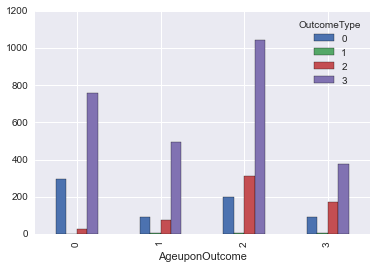

In [62]:
ages_n_outcomes.plot.bar()

And here are our codes.

In [47]:
encoder.inverse_transform([0, 1, 2, 3])

array(['Adoption', 'Died', 'Euthanasia', 'Transfer'], dtype=object)

So, we see that puppies are more likely to be adopted and adults are more likely to be euthanized, but looking at our counts again will help us interpret this data.

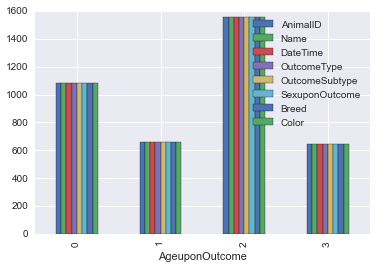

In [69]:
counts = train_dogs.groupby('AgeuponOutcome').count().plot.bar()

In [70]:
# We should really do the same thing with color...

len(train_dogs.Color.unique())
color = {}

for i, c in enumerate(train_dogs.Color.unique()):
    color[c] = i
    
train_dogs['Color'] = train_dogs.Color.map( color ).astype(int)

In [71]:
# We could also do something very cool with text analysis for names, but we'll keep it simple and go length

train_dogs['Name'] = train_df.Name.apply(lambda x: len(str(x)))
train_dogs.interpolate().head() # could have used dropna().median()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color
2,A686464,6,2015-01-31 12:28:00,0,0,0,2,Pit Bull Mix,0
5,A677334,4,2014-04-25 13:04:00,3,1,3,0,Cairn Terrier/Chihuahua Shorthair,1
12,A684601,6,2016-02-03 11:27:00,0,0,0,2,Pit Bull Mix,2
20,A670658,6,2014-01-19 15:03:00,3,1,2,0,Queensland Heeler Mix,3
31,A707341,6,2015-07-15 15:25:00,3,1,2,0,Labrador Retriever Mix,3


We've done a lot of pre-processing and have a good idea what our dataset looks like.  The Breed feature will be tricky, though, so let's save what we've done.

In [72]:
# Save our clean dataframe to csv so we don't need to do this again.
train_dogs.to_csv(os.path.join(data_dir, "dogs_clean_train.csv"))

### K-Means for Breed types

In [73]:
# Let's reload our dataframe.

train_dogs = pd.read_csv(os.path.join(data_dir, "dogs_clean_train.csv"))

In [40]:
train_dogs.Breed.unique()

array(['Pit Bull Mix', 'Cairn Terrier/Chihuahua Shorthair',
       'Queensland Heeler Mix', 'Labrador Retriever Mix',
       'Chihuahua Shorthair Mix', 'Yorkshire Terrier Mix', 'Pointer Mix',
       'English Foxhound', 'Cardigan Welsh Corgi/Chihuahua Shorthair',
       'Chihuahua Shorthair', 'Lhasa Apso', 'German Shepherd Mix',
       'Border Collie Mix', 'Boxer Mix', 'Chihuahua Shorthair/Dachshund',
       'Miniature Pinscher/Chihuahua Shorthair', 'Dachshund Mix',
       'Australian Cattle Dog Mix', 'Catahoula/Labrador Retriever',
       'Whippet Mix', 'Rat Terrier Mix', 'English Pointer Mix',
       'Labrador Retriever/Pit Bull', 'Basset Hound/Labrador Retriever',
       'Airedale Terrier Mix', 'Chihuahua Shorthair/Rat Terrier',
       'Cocker Spaniel', 'Plott Hound Mix', 'Dachshund',
       'Border Collie/Labrador Retriever', 'Great Dane', 'Akita/Pit Bull',
       'Labrador Retriever', 'Rottweiler Mix',
       'Labrador Retriever/Blue Lacy', 'Dachshund/Chihuahua Shorthair',
       '

In [41]:
len(train_dogs.Breed.unique())

626

In [42]:
# Could do something with a countvectorizer for Breed & Color, but we'll stick to simple here

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer()

In [43]:
def split_into_lemmas(message):
    words = TextBlob(message.replace("/", "").lower()).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

train_dogs.Breed.head().apply(split_into_lemmas)

2                         [pit, bull, mix]
5     [cairn, terrierchihuahua, shorthair]
12                        [pit, bull, mix]
20               [queensland, heeler, mix]
31              [labrador, retriever, mix]
Name: Breed, dtype: object

In [50]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(train_dogs.Breed)
len(bow_transformer.vocabulary_)


550

In [51]:
bow_transformer.get_feature_names()[3]

'akita/labrador'

In [52]:
breed_bow = bow_transformer.transform(train_dogs.Breed)
print( 'sparse matrix shape:', breed_bow.shape)
print( 'number of non-zeros:', breed_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * breed_bow.nnz / (breed_bow.shape[0] * breed_bow.shape[1])))

sparse matrix shape: (3950, 550)
number of non-zeros: 11171
sparsity: 0.51%


In [53]:
print(breed_bow[1])

  (0, 85)	1
  (0, 440)	1
  (0, 502)	1


In [54]:
train_dogs['Breedbow'] = bow_transformer.fit_transform(train_dogs.Breed)

In [59]:
train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color,Breedbow
2,A686464,Pearce,2015-01-31 12:28:00,0,0,0,1,Pit Bull Mix,Blue/White,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ..."
5,A677334,Elsa,2014-04-25 13:04:00,3,1,3,2,Cairn Terrier/Chihuahua Shorthair,Black/Tan,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ..."
12,A684601,Rocket,2016-02-03 11:27:00,0,0,0,1,Pit Bull Mix,Brown,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ..."
20,A670658,Anders,2014-01-19 15:03:00,3,1,2,2,Queensland Heeler Mix,Black/White,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ..."
31,A707341,Murphy,2015-07-15 15:25:00,3,1,2,2,Labrador Retriever Mix,Black/White,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ..."


In [60]:
tfidf_transformer = TfidfTransformer().fit(breed_bow)

In [61]:
breed_tfidf = tfidf_transformer.transform(breed_bow)

In [63]:
# Select number of clusters for KMeans clustering
n_clusters = 5

In [64]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, verbose=0)

In [69]:
km_breeds = km.fit_predict(breed_tfidf)

In [70]:
km.predict(breed_tfidf[4])

array([3], dtype=int32)

In [71]:
# Visualizing the K-Means clusters via TSNE
# t-distributed Stochastic Neighbor Embedding.

from sklearn.manifold import TSNE

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [72]:
from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(breed_tfidf)

In [73]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3950
[t-SNE] Computed conditional probabilities for sample 2000 / 3950
[t-SNE] Computed conditional probabilities for sample 3000 / 3950
[t-SNE] Computed conditional probabilities for sample 3950 / 3950
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.2211093, gradient norm = 0.0087803
[t-SNE] Iteration 50: error = 1.1245372, gradient norm = 0.0059033
[t-SNE] Iteration 75: error = 0.7733550, gradient norm = 0.0044605
[t-SNE] Iteration 100: error = 0.6746730, gradient norm = 0.0049470
[t-SNE] Error after 100 iterations with early exaggeration: 0.674673
[t-SNE] Iteration 125: error = 0.5096617, gradient norm = 0.0049027
[t-SNE] Iteration 150: error = 0.4722413, gradient norm = 0.0044057
[t-SNE] Iteration 175: error = 0.4505382, gradient norm = 0.0044037
[t-SNE] Iteration 200: error = 0.4466057, gradient norm = 0.0040005
[t-SNE] Iterat

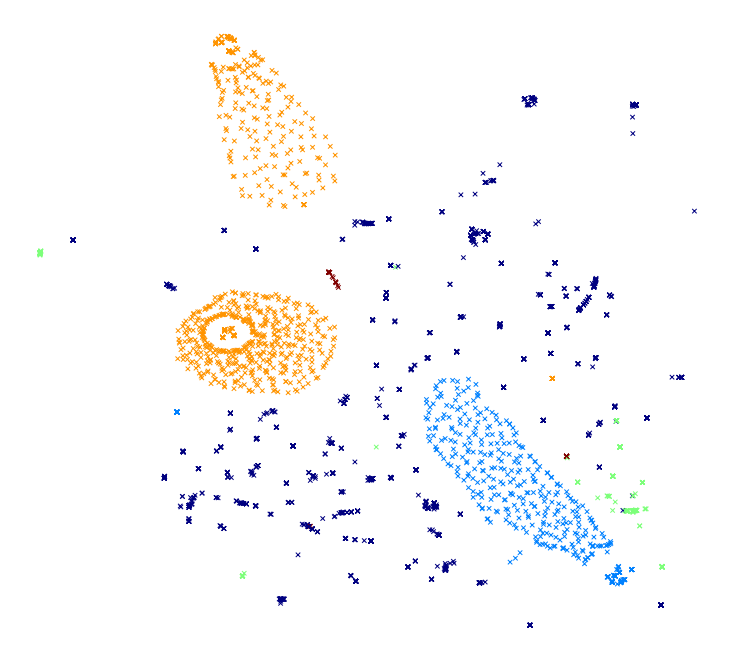

In [74]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=km.labels_, marker="x")

In [75]:
train_dogs['BreedKMeans'] = km_breeds

In [76]:
train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color,Breedbow,BreedKMeans
2,A686464,Pearce,2015-01-31 12:28:00,0,0,0,1,Pit Bull Mix,Blue/White,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",3
5,A677334,Elsa,2014-04-25 13:04:00,3,1,3,2,Cairn Terrier/Chihuahua Shorthair,Black/Tan,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",0
12,A684601,Rocket,2016-02-03 11:27:00,0,0,0,1,Pit Bull Mix,Brown,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",3
20,A670658,Anders,2014-01-19 15:03:00,3,1,2,2,Queensland Heeler Mix,Black/White,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",0
31,A707341,Murphy,2015-07-15 15:25:00,3,1,2,2,Labrador Retriever Mix,Black/White,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",3


In [90]:
train_dogs.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color', 'Breedbow',
       'BreedKMeans'],
      dtype='object')

In [91]:
train_dogs.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color,Breedbow,BreedKMeans
2,A686464,6,2015-01-31 12:28:00,0,0,0,1,Pit Bull Mix,0,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",3
5,A677334,4,2014-04-25 13:04:00,3,1,3,2,Cairn Terrier/Chihuahua Shorthair,1,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",0
12,A684601,6,2016-02-03 11:27:00,0,0,0,1,Pit Bull Mix,2,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",3
20,A670658,6,2014-01-19 15:03:00,3,1,2,2,Queensland Heeler Mix,3,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",0
31,A707341,6,2015-07-15 15:25:00,3,1,2,2,Labrador Retriever Mix,3,"(0, 307)\t1\n (0, 61)\t1\n (0, 276)\t1\n ...",3


In [92]:
# Work out a test_train_split to see how we do
X = train_dogs.drop(['AnimalID', 'DateTime', 'OutcomeType',
                     'OutcomeSubtype', 'Breed', 'Breedbow'], axis=1)
X.dtypes

Name              int64
SexuponOutcome    int64
AgeuponOutcome    int64
Color             int64
BreedKMeans       int32
dtype: object

In [93]:
X.AgeuponOutcome.replace('NA',0)

/Users/christopherallison/.virtualenvs/py_twi/lib/python3.4/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


2        1
5        2
12       1
20       2
31       2
34       1
61       3
66       2
67       2
71       1
75       1
80       0
84       3
92       3
93       1
96       2
101      1
111      0
114      2
117      2
133      1
139      2
147      2
154      1
160      3
181      1
188      1
190      3
198      2
213      1
        ..
26492    2
26498    1
26501    3
26503    1
26517    1
26521    3
26523    1
26533    1
26553    3
26557    2
26563    0
26598    1
26613    3
26615    2
26616    1
26628    0
26629    1
26633    3
26638    3
26657    0
26670    0
26688    2
26690    1
26694    3
26699    1
26701    2
26708    1
26710    2
26711    0
26716    2
Name: AgeuponOutcome, dtype: int64

In [94]:
X.columns

Index(['Name', 'SexuponOutcome', 'AgeuponOutcome', 'Color', 'BreedKMeans'], dtype='object')

In [99]:
X.to_csv(os.path.join(data_dir, "prepared_dogs_df.csv"))

In [100]:
train_features = X.values
train_features[:10]

array([[ 6,  0,  1,  0,  3],
       [ 4,  3,  2,  1,  0],
       [ 6,  0,  1,  2,  3],
       [ 6,  2,  2,  3,  0],
       [ 6,  2,  2,  3,  3],
       [ 7,  0,  1,  2,  1],
       [12,  1,  3,  4,  2],
       [ 4,  0,  2,  3,  0],
       [ 5,  3,  2,  5,  0],
       [ 8,  0,  1,  6,  3]])

In [101]:
dummy_y

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.]])

In [102]:
train_target = np_utils.to_categorical(train_dogs['OutcomeType'].values)
train_target

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.]])

In [103]:
simple_target = train_dogs.OutcomeType.values
simple_target

array([0, 3, 0, ..., 3, 3, 0])

In [104]:
# Set up our train_test_split

X_train, x_test, y_train, y_test = train_test_split(train_features,
                                          train_target,
                                          test_size=0.2,
                                          random_state=42)

In [105]:

simple_X_train, simple_x_test, simple_y_train, simple_y_test = train_test_split(train_features,
                                          simple_target,
                                          test_size=0.2,
                                          random_state=42)

In [106]:
# New we finally get to the classifier!

clf = RandomForestClassifier(n_estimators=100)

In [107]:
# Categorical classifier
clf = clf.fit(X_train, y_train)
score = clf.score(X_train, y_train)
"Mean accuracy of Random Forest: {0}".format(score)

'Mean accuracy of Random Forest: 0.879746835443038'

In [108]:
# Simple classifier
S_clf = clf.fit(simple_X_train, simple_y_train)
score = clf.score(simple_X_train, simple_y_train)
"Mean accuracy of simple Random Forest: {0}".format(score)

'Mean accuracy of simple Random Forest: 0.894620253164557'

In [111]:
clf.predict(x_test[0].reshape(1, -1))

array([3])

In [112]:
S_clf.predict(simple_x_test[0].reshape(1, -1))

array([3])

In [113]:
outcomes

array(['Adoption', 'Transfer', 'Euthanasia', 'Died'], dtype=object)

In [114]:
def reverse_dict_search(d, target):
    for k, v in d.items():
        if v == target:
            return k

In [145]:
x_test[5]

array([5, 3, 3, 7, 1])

In [146]:
X.head(1)

,Name,SexuponOutcome,AgeuponOutcome,Color,BreedKMeans
2,6,0,1,0,3


In [180]:
def predict_outcome(animal):
    
    outcomes = [0, 1, 2, 3]
    
    prediction = clf.predict(animal).reshape(1,-1)
    probability = clf.predict_proba(animal)
    option_probability = list(probability[np.argmax(prediction)][0])[1]
    
    name, sex, age, animal_color, animal_breed = animal
    
    print("Name length:{}".format(name))
    print("Sex:{}".format(reverse_dict_search(sex_outcome, sex)))
    print("Age group:{}".format(age_encoder.inverse_transform(age)))
    print("Breed group:{}".format(animal_breed))
    print("Color:{}".format(reverse_dict_search(color, animal_color)))
    print("************\n")
    print("Prediction: {} ({})\n".format(encoder.inverse_transform(
                np.argmax(prediction)), round(option_probability, 2)))
    print("****Breakdown****")
    
    for oc in outcomes:
        print("{}: {}, {}".format(encoder.inverse_transform(oc),
                                  round(list(probability[oc])[0][0],2),
                                 round(list(probability[oc])[0][1],2)))

In [181]:
predict_outcome(x_test[3])

Name length:6
Sex:Spayed Female
Age group:senior
Breed group:0
Color:Brown/Black
************

Prediction: Adoption (0.73)

****Breakdown****
Adoption: 0.27, 0.73
Died: 1.0, 0.0
Euthanasia: 0.96, 0.04
Transfer: 0.77, 0.23


/Users/christopherallison/.virtualenvs/py_twi/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/christopherallison/.virtualenvs/py_twi/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [182]:
# Evaluate the model
print (X_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(3160, 5) (3160, 4)
(790, 5) (790, 4)


In [183]:
clf = clf.fit(X_train, y_train)
y_predict = clf.predict(x_test)

print ("Accuracy = %.2f" % (accuracy_score(y_test, y_predict)))

Accuracy = 0.58


In [184]:
# Create classification report for test data

categories = ['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died']

print(classification_report(y_test, 
                            y_predict, 
                            target_names=categories))

                 precision    recall  f1-score   support

Return_to_owner       0.33      0.23      0.27       129
     Euthanasia       0.00      0.00      0.00         0
       Adoption       0.28      0.16      0.20       113
       Transfer       0.71      0.75      0.73       548

    avg / total       0.58      0.58      0.58       790



/Users/christopherallison/.virtualenvs/py_twi/lib/python3.4/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [167]:
# Metrics for the simple labels classifier

S_y_predict = S_clf.predict(simple_x_test)

print ("Accuracy = %.2f" % (accuracy_score(simple_y_test, S_y_predict)))

model_score = S_clf.score(simple_x_test, simple_y_test)
print ("Model Score %.2f \n" % (model_score))

confusion_matrix = metrics.confusion_matrix(simple_y_test, S_y_predict)
print ("Confusion Matrix \n", confusion_matrix)

print ("          Predicted")
print ("         |  0  |  1  |")
print ("         |-----|-----|")
print ("       0 | %3d | %3d |" % (confusion_matrix[0, 0],
                                   confusion_matrix[0, 1]))
print ("Actual   |-----|-----|")
print ("       1 | %3d | %3d |" % (confusion_matrix[1, 0],
                                   confusion_matrix[1, 1]))
print ("         |-----|-----|")

ValueError: Can't handle mix of multiclass and multilabel-indicator

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    # Simple plot based on the Iris sample CM
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

TypeError: Image data can not convert to float

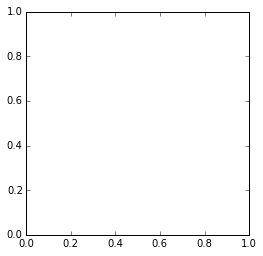

In [171]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(confusion_matrix, categories, title="Animal Sanctuary Confusion Matrix")

In [ ]:
print(average_precision_score(y_test, y_predict))

In [189]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp

In [190]:
print(roc_auc_score(y_test, y_predict))

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [188]:
n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

NameError: name 'roc_curve' is not defined

In [ ]:
##############################################################################
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [185]:
# Plot the importance of the different features

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]

1. feature 3 (0.520316)
2. feature 0 (0.206176)
3. feature 2 (0.098494)
4. feature 1 (0.096589)
5. feature 4 (0.078425)


/Users/christopherallison/.virtualenvs/py_twi/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


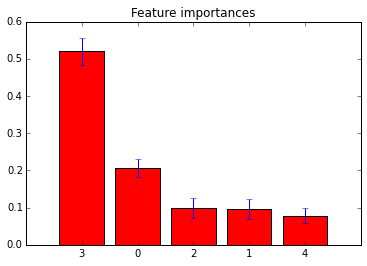

In [186]:
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [187]:
for i in [3, 0, 2, 1, 4]:
    print("Feature {}: {}".format(i, X.columns[i]))

Feature 3: Color
Feature 0: Name
Feature 2: AgeuponOutcome
Feature 1: SexuponOutcome
Feature 4: BreedKMeans


In [ ]:
# The data is now ready to go. So lets fit to the train, then predict to the test!
# Convert back to a numpy array
train_data = train_df.values
test_data = test_df.values

In [ ]:
print 'Training...'
forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit( train_data[0::,1::], train_data[0::,0] )

In [ ]:
print 'Predicting...'
output = forest.predict(test_data).astype(int)

In [ ]:
predictions_file = open("myfirstforest.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print 'Done.'